In [1]:
import math
from typing import Optional

import torch
from botorch.acquisition.acquisition import AcquisitionFunction
from botorch.acquisition.objective import PosteriorTransform
from botorch.models.gp_regression import FixedNoiseGP
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils.probability.utils import (
    log_ndtr as log_Phi,
    log_phi,
    log_prob_normal_in,
    ndtr as Phi,
    phi,
)
from botorch.utils.transforms import convert_to_target_pre_hook, t_batch_mode_transform
from torch import Tensor
from botorch.optim import optimize_acqf
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.analytic import AnalyticAcquisitionFunction
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qKnowledgeGradient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
plt.rcParams["figure.figsize"] = (10,10)

In [2]:
class DiverseAcquisitionFunction(AnalyticAcquisitionFunction):
    def __init__(self, model, lambda_, epsilon_, best_f):
        super().__init__(model=model)
        self.register_buffer("lambda_", torch.as_tensor(lambda_))
        self.register_buffer("epsilon_", torch.as_tensor(epsilon_))
        self.register_buffer("best_f", torch.as_tensor(best_f))

    @t_batch_mode_transform(expected_q = 1)
    def forward(self, X: Tensor) -> Tensor:
        mean, sigma = self._mean_and_sigma(X)
        factor = (1 + self.epsilon_ ) if self.best_f > 0 else (1 - self.epsilon_)
        
        ei_portion = Phi((self.best_f - mean)/sigma) * (self.best_f - mean)
        dei_portion = phi((self.best_f - mean)/sigma) + self.lambda_ * Phi((factor * self.best_f - mean)/sigma)
        
        return ei_portion + dei_portion * sigma

In [3]:
import warnings
warnings.filterwarnings("ignore")
from botorch.test_functions import Branin, Griewank, SixHumpCamel, HolderTable, Hartmann, Michalewicz

def Gramacy(x):
    if len(x.shape) == 1:
        return torch.tensor(-np.abs(x[0] * np.exp(-(x[0]**2) - (x[1]**2))))
    
    lst = [] 
    for i in range(x.shape[0]):
        val = -np.abs(x[i][0] * np.exp(-(x[i][0]**2) - (x[i][1]**2)))
        lst.append(val)
    return torch.tensor(lst)

In [4]:
from scipy.stats import qmc

def scalarize_input(train_x, bounds):
    train_x_i = torch.clone(train_x)
    for dim in range(bounds.shape[1]):
        bound = bounds[:, dim]
        train_x_i[:, dim] -= bound[0]
        train_x_i[:, dim] /= ((bound[1] - bound[0]))
    return train_x_i

def revert_input(train_x_i, bounds):
    train_x = torch.clone(train_x_i)
    for dim in range(bounds.shape[1]):
        bound = bounds[:, dim]
        train_x[:, dim] *= ((bound[1] - bound[0]))
        train_x[:, dim] += bound[0]
    return train_x
    
def scalarize_output(train_obj):
    mean = train_obj.mean().item()
    std = train_obj.std().item()
    return (train_obj - mean)/std, mean, std

def revert_output(train_obj, mean, std):
    return train_obj * std + mean

def lhc_opt_loop(opt_func, bounds, num_sim):
    dim = bounds.shape[1]
    sampler = qmc.LatinHypercube(d = dim)
    obs_x = revert_input(torch.tensor(sampler.random(1 + num_sim * dim)), bounds)
    
    obs_obj = opt_func(obs_x)
    
    cum_min = np.minimum.accumulate(obs_obj.numpy())
    
    return obs_x, obs_obj, cum_min

def bayes_opt_loop(opt_func, bounds, num_start, num_sim, acqf_func, param_settings = {}):
    dim = bounds.shape[1]
    
    #actual observed 
    obs_x = revert_input(torch.rand(num_start * dim, dim), bounds)
    obs_obj = opt_func(obs_x).unsqueeze(-1)
    
    #regularized inputs to model
    model_bounds = torch.tensor([[0.0] * dim, [1.0] * dim])
    model_input = scalarize_input(obs_x, bounds)
    model_output, mean, sigma = scalarize_output(obs_obj)
    var = torch.zeros(model_output.shape) + 10**(-6)

    model = FixedNoiseGP(train_X = model_input, train_Y = model_output, train_Yvar = var)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    
    best_so_far = []
    best_so_far.append(model_output.min().item() * sigma + mean)

    for i in range(num_sim * dim):
        best_f = model_output.min()
        
        acqf = acqf_func(model = model, best_f = model_output.min(), **param_settings)
        
        new_point, _ = optimize_acqf(acqf, bounds=model_bounds, q = 1, num_restarts = 5, raw_samples = 100)
        eval_point = revert_input(new_point, bounds)
        eval_result = opt_func(eval_point).expand(1, 1)
        reg_eval_result = (eval_result - mean)/sigma

        model_input = torch.cat((model_input, new_point), 0)
        model_output = torch.cat((model_output, reg_eval_result), 0)
        var = torch.cat((var, torch.as_tensor(10**-6).expand(1,1)), 0)

        #condition observation
        
        model = model.condition_on_observations(X = new_point, Y = reg_eval_result, 
                                                noise = torch.as_tensor(5 * 10**-2).expand(1,1))

        #change parameters for output and refit model
        if i % 50 == 0:
            model_output = revert_output(model_output, mean, sigma)
            model_output, mean, sigma = scalarize_output(model_output)
            model = FixedNoiseGP(train_X = model_input, train_Y = model_output, train_Yvar = var)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_mll(mll)
        
        best_so_far.append(min(best_so_far[len(best_so_far) - 1], eval_result.item()))

    obs_x = revert_input(model_input, bounds)
    obs_obj = revert_output(model_output, mean, sigma)
    return obs_x, obs_obj, best_so_far

def get_sil_score(points, max_k = 5):
    if points.shape[0] < 6:
        return 1
    
    sil = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters = k).fit(points)
        labels = kmeans.labels_
        sil.append(silhouette_score(points, labels, metric = 'euclidean'))

    return np.argmax(np.array(sil)) + 1

def evaluate(true_min, train_obj, train_x, epsilon_):
    factor = (1 + epsilon_) if true_min > 0 else (1 - epsilon_)

    torch_ind = train_obj < factor * true_min
    ind = []
    i = 0
    for val in torch_ind:
        if val:
            ind.append(i)
        i += 1

    feasible_sol, feasible_x = train_obj[ind], train_x[ind]
    avg_dist = -1

    ind = 0
    for i in range(feasible_sol.shape[0]):
        for j in range(i + 1, feasible_sol.shape[0]):
            val1, val2 = feasible_x[i], feasible_x[j]
            avg_dist += torch.norm(val1 - val2).item()
            ind += 1
    
    avg_dist = -1 if ind == 0 else avg_dist/ind
    
    cluster_num = get_sil_score(feasible_x)
        
    return feasible_sol, feasible_x, avg_dist, cluster_num


In [5]:
opt_func = [[Branin(), torch.tensor([[-5.0, 0.0], [10.0, 15.0]]), 0.5, "Branin"],
             [Griewank(), torch.tensor([[-5.0] * 2, [5.0] * 2]), 0.3, "Griewank"],
             [SixHumpCamel(), torch.tensor([[-3.0, -2.0], [3.0, 2.0]]), -1.2, "SixHumpCamel"],
            [HolderTable(), torch.tensor([[-10, -10.0], [10.0, 10.0]]), -19.0, "HolderTable"],
             [Gramacy, torch.tensor([[-2.0, -2.0], [6.0, 6.0]]), -0.4, "Gramacy"]]

DEI_param_settings = {"lambda_":1, "epsilon_":0.1}
EI_param_settings = {"maximize":False}
know_param_settings = {"num_fantasies":50}

acf_func = [(DiverseAcquisitionFunction, DEI_param_settings, "DEI"),
            (ExpectedImprovement, EI_param_settings, "EI"), ]

def testing_loop(num_start, num_sim, func_loop, acf_func, eps, num_trials):
    columns = ["opt_func", "acf_func", "num_sol", "curr_min", "avg_dist", "num_cluster", "trial"]
    results = pd.DataFrame(columns = columns)
    
    min_sol = {}
    all_x = {}
    
    for func_list in func_loop:
        opt_name = func_list[3]
        dim = func_list[1].shape[1]
        for acf_list in acf_func:
            _, _, acf_name = acf_list
            
            min_sol[(opt_name, acf_name)] = np.zeros((num_trials, dim * num_sim +1))
        min_sol[(opt_name, 'LHC')] = np.zeros((num_trials, dim * num_sim +1))
    
    for trial in range(num_trials):
        
        for func_list in func_loop:
            opt_func = func_list[0]
            bounds = func_list[1]
            true_min = func_list[2]
            opt_name = func_list[3]

            for acf_list in acf_func:
                acf, settings, acf_name = acf_list     

                x, y, best_so_far = bayes_opt_loop(opt_func, bounds, num_start, num_sim, acf, settings)

                sol_set, feas_x, avg_dist, cluster_num = evaluate(true_min, y, x, eps)

                min_sol[(opt_name, acf_name)][trial] = best_so_far
                all_x[(opt_name, acf_name, trial + 1)] = [x.numpy(), feas_x.numpy()]

                results.loc[len(results)] = [opt_name, acf_name, len(sol_set), y.min().item(), avg_dist, cluster_num, trial + 1]
            
            x, y, best_so_far = lhc_opt_loop(opt_func, bounds, num_sim)
            sol_set, feas_x, avg_dist, cluster_num = evaluate(true_min, y, x, eps)
            min_sol[(opt_name, 'LHC')][trial] = best_so_far
            
            results.loc[len(results)] = [opt_name, "LHC", len(sol_set), y.min().item(), avg_dist, cluster_num, trial + 1]
    return results, min_sol, all_x

results, min_sol, all_x  = testing_loop(5, 20, opt_func, acf_func, 0.5, 25)

In [6]:
def plot_min_sol(min_sol_copy, opt_func, acf_func, include_lhc = False, start_index = 0):
    
    min_sol = min_sol_copy.copy()
    if not include_lhc:
        prop = {}
        for key in min_sol:
            if key[1] != 'LHC':
                prop[key] = min_sol[key]

        min_sol = prop

    keys = list(min_sol.keys())
    
    assert len(keys) == opt_func * acf_func

    color_list = ['blue', 'red', 'green', 'yellow']
    plt.rcParams["figure.figsize"] = (10,10)
    ind = 0
    fig, ax = plt.subplots(opt_func)
    fig.tight_layout(pad = 1.0)
    
    acf_list = []
    for i in range(acf_func):
        acf_list.append(keys[i][1])
    
    
    for i in range(opt_func):
        length = min_sol[keys[ind]].shape[1]
        for j in range(acf_func):
            data = min_sol[keys[ind]][:, start_index:]
            mean = np.median(data, axis = 0)
            per_25 = np.quantile(data, q = 0.25, axis = 0)
            per_75 = np.quantile(data, q = 0.75, axis = 0)
            ax[i].plot(np.arange(start_index, length), mean, color = color_list[j], label = acf_list[j])
            ax[i].fill_between(np.arange(start_index, length), per_25, per_75, color = color_list[j], alpha=.15)
            ax[i].legend()
            ax[i].set_title(keys[ind][0])
            ind += 1
            
    plt.show()

In [32]:
def plot_feature_hist(results, feature):
    functions = results['opt_func'].unique()
    acf_func = np.delete(results['acf_func'].unique(), np.where(results['acf_func'].unique() == 'LHC'))
    
    fig, ax = plt.subplots(len(functions))
    fig.tight_layout(pad = 2.0)
    
    ind = 0
    for function in functions:
        for acq in acf_func:
            data = results[(results.opt_func == function)&(results.acf_func == acq)][feature]
      
            ax[ind].hist(data, density = True,alpha = 0.5, label = acq)

            ax[ind].set_title(function)
            ax[ind].legend()

        ind += 1

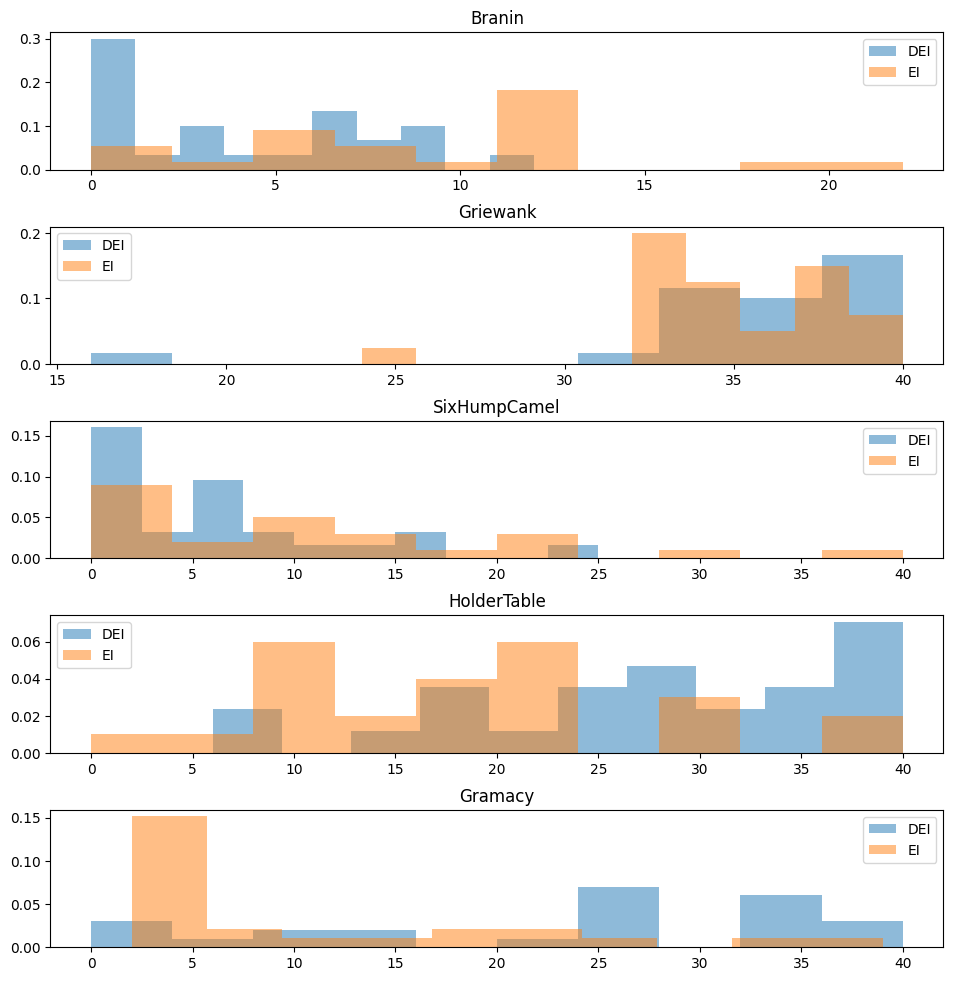

In [33]:
plot_feature_hist(results, 'num_sol')

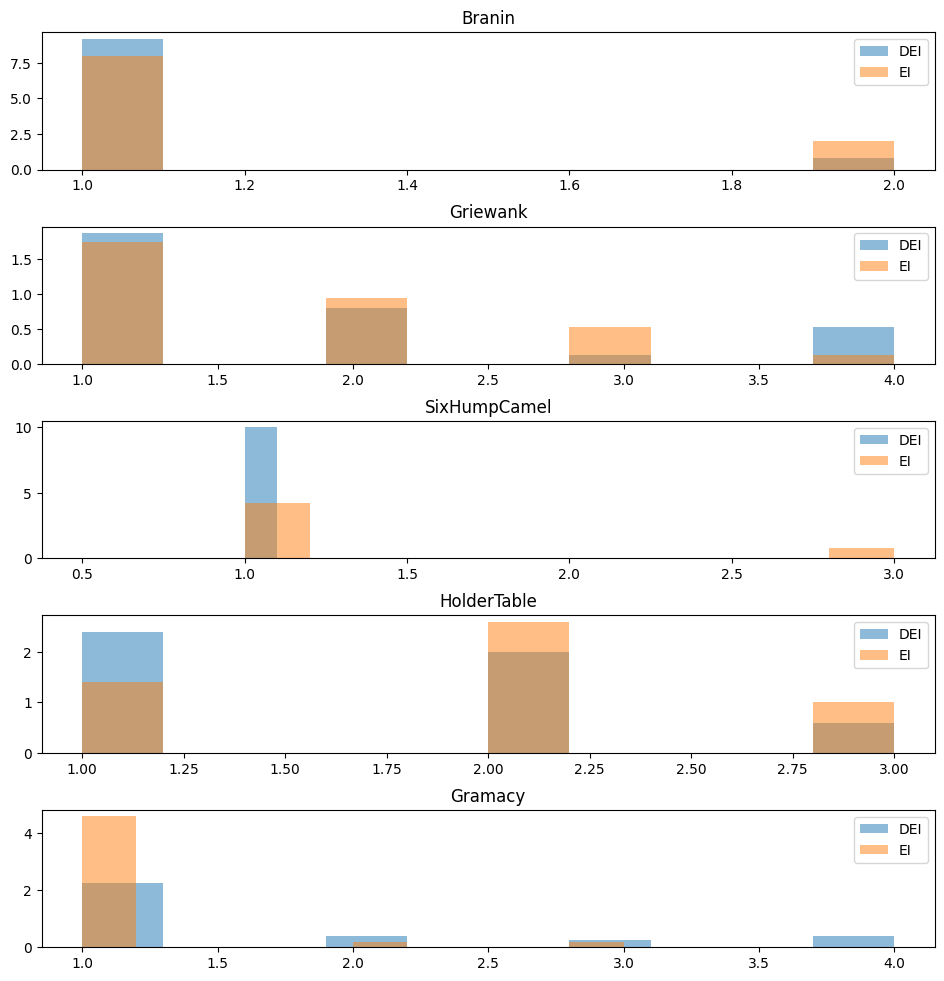

In [34]:
plot_feature_hist(results, 'num_cluster')

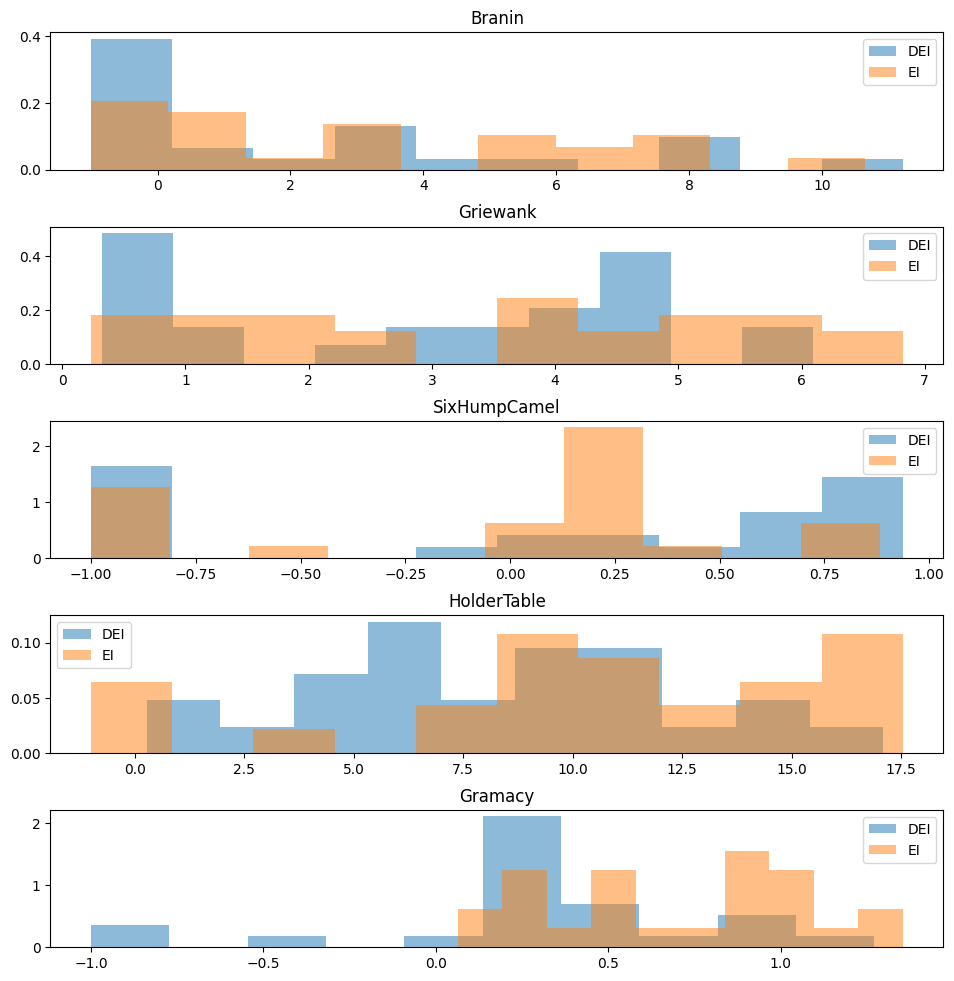

In [35]:
plot_feature_hist(results, 'avg_dist')

In [11]:
results.groupby(['opt_func', 'acf_func'])[['curr_min', 'avg_dist', 'num_sol', 'num_cluster']].mean().reset_index()

,opt_func,acf_func,curr_min,avg_dist,num_sol,num_cluster
0,Branin,DEI,0.635944,2.226825,4.20,1.08
1,Branin,EI,0.497014,3.069778,8.96,1.20
2,Branin,LHC,1.589802,-0.752526,0.36,1.00
3,Gramacy,DEI,-0.389694,0.316478,23.08,1.64
4,Gramacy,EI,-0.390560,0.714249,11.20,1.12
5,Gramacy,LHC,-0.356929,0.271152,2.36,1.00
6,Griewank,DEI,0.014001,2.945179,35.72,1.80
7,Griewank,EI,0.004230,3.441061,34.76,1.72
8,Griewank,LHC,0.051435,6.086035,7.08,2.16
9,HolderTable,DEI,-17.546349,8.391111,27.64,1.64


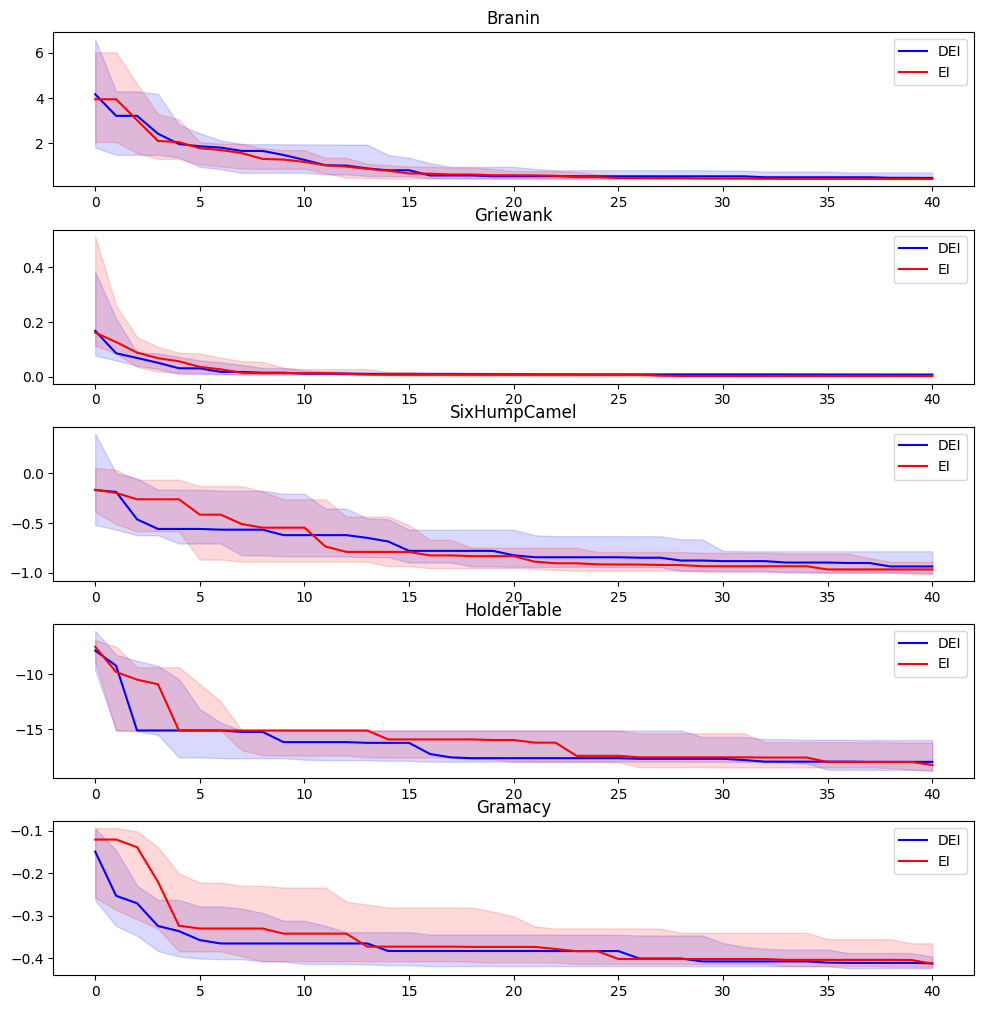

In [12]:
plot_min_sol(min_sol, 5, 2, include_lhc = False, start_index = 0)

In [13]:
def plot_points_dist(all_x_copy, num_func, num_acqf, trial):
    prog = all_x_copy.copy()
    
    all_x = {}

    for key in prog:
        if key[2] == trial:
            all_x[key] = prog[key]

    
    fig, ax = plt.subplots(num_func, num_acqf)
    fig.tight_layout(pad = 1)
    
    keys = sorted(list(all_x.keys()))
    ind = 0
    for i in range(num_func):
        for k in range(num_acqf):
            ax[i][k].scatter(all_x[keys[ind]][0][:, 0],all_x[keys[ind]][0][:, 1], label = "Solutions")
            ax[i][k].scatter(all_x[keys[ind]][1][:, 0],all_x[keys[ind]][1][:, 1], label = "Feasible", color = "red")
            ax[i][k].set_title(keys[ind][0] + " "+ keys[ind][1])
            ax[i][k].legend()
            ind += 1
    plt.show()

In [14]:
def get_dist_metric(all_x, minima, num_trials):
    
    result_map = {}
    for key in all_x:
        opt_name, acf, trial = key
        
        feasible_x = all_x[key][0]
        
        local_points = minima[opt_name]
        
        res = np.zeros(len(local_points))
        
        ind = 0
        for min_x in local_points:
            min_dist = float("inf")
            for point in feasible_x:
                min_dist = min(np.linalg.norm(point - min_x), min_dist)
            
            res[ind] = min_dist
            ind += 1
        
        if (opt_name, acf) not in result_map:
            result_map[(opt_name, acf)] = np.zeros(len(local_points))
        
        result_map[(opt_name, acf)] += res/num_trials
    
    return result_map

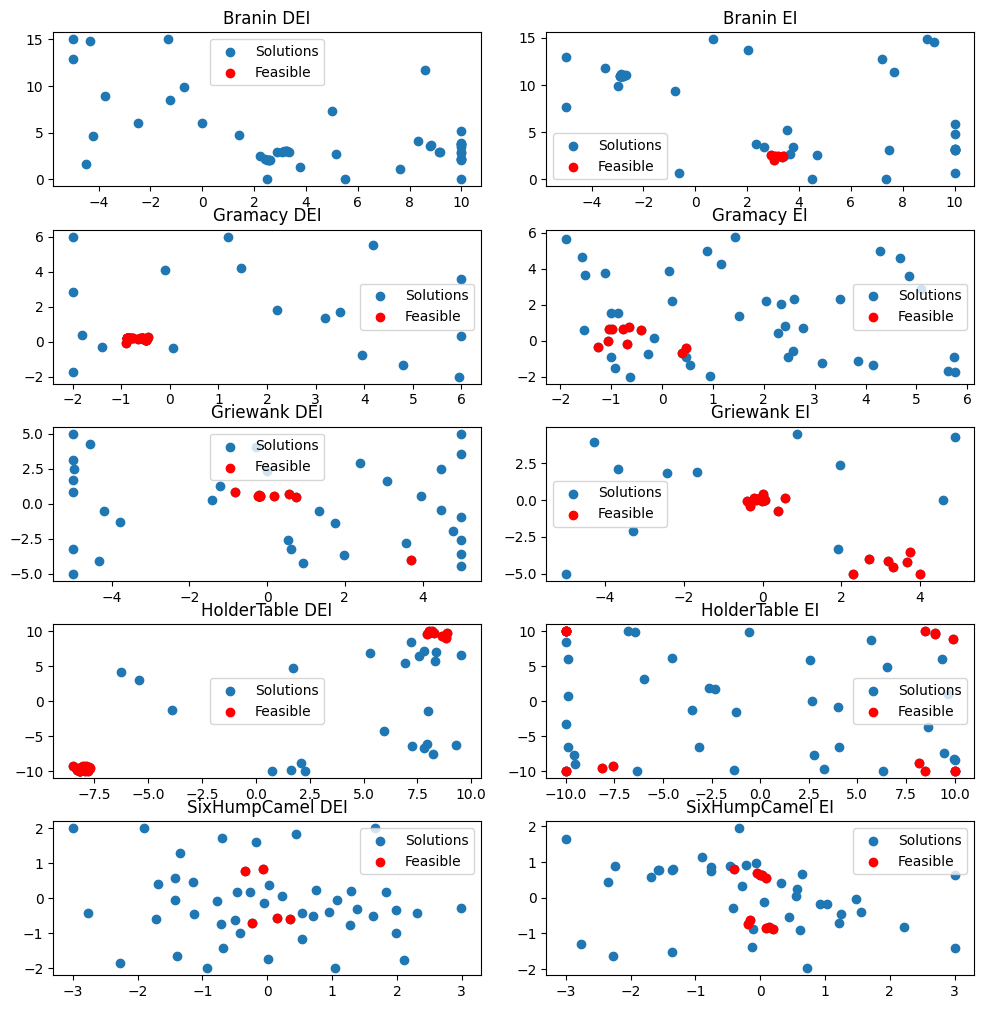

In [15]:
plot_points_dist(all_x, 5, 2, 25)

In [16]:
minima = {
    'Branin':[np.array([-3.14, 12.275]), np.array([3.14, 2.275]), np.array([9.42, 2.475])],
    'SixHumpCamel':[np.array([0.09, -0.71]), np.array([-0.09, 0.71])],
    'Griewank':[np.array([0, 0])],
    'Gramacy':[np.array([0.8, 0]), np.array([-0.8, 0])],
    'HolderTable':[np.array([8.05, 9.66]), np.array([-8.05, 9.66]), np.array([8.05, -9.66]), np.array([-8.05, -9.66])]
}

dist_metric = get_dist_metric(all_x, minima, 25)

In [17]:
def plot_dist_metric(dist_metric, num_func = 4):
    
    fig, ax = plt.subplots(num_func, 2, sharey='row')
    fig.tight_layout(pad = 1.2)
    
    ind = 0
    for key in dist_metric:
        xs = ['x' + str(k) for k in range(1, len(dist_metric[key]) + 1)]
        ax[ind // 2][ind % 2].bar(xs, dist_metric[key])
        ax[ind // 2][ind % 2].set_title(key[0] + " " + key[1])
        ind += 1
    
    plt.show()

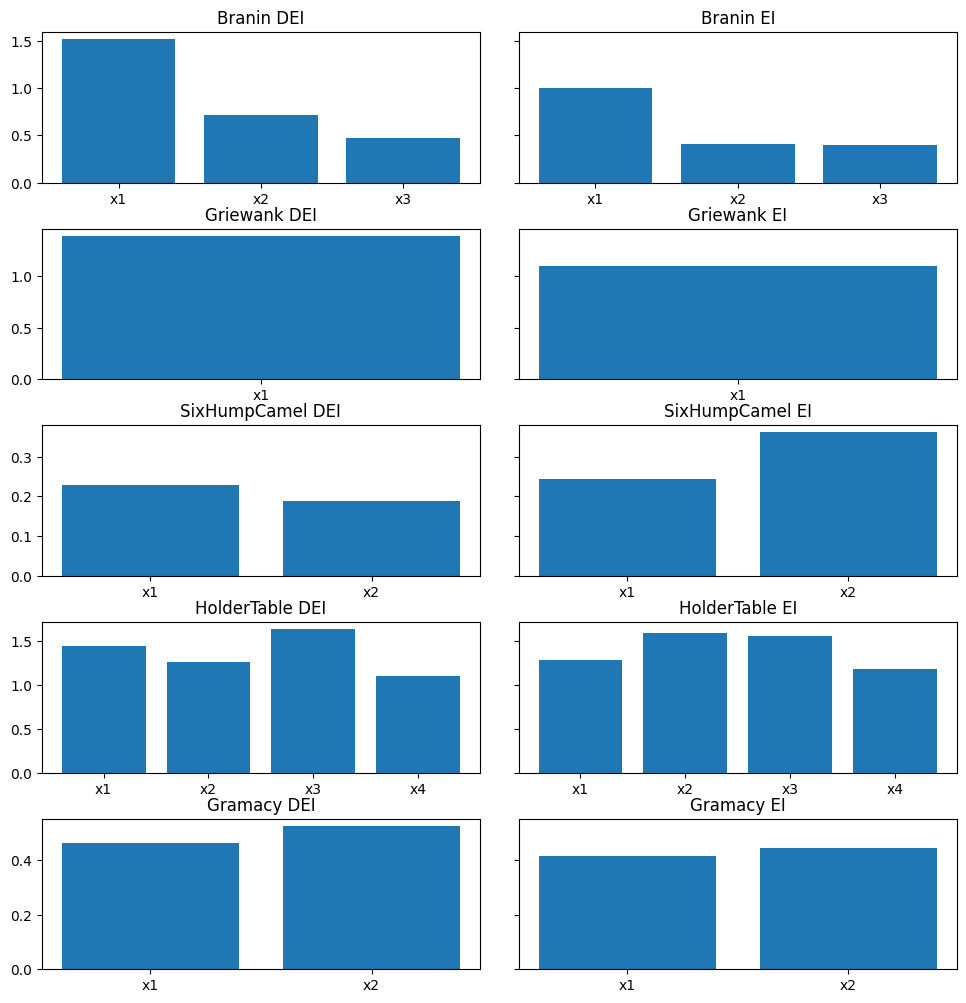

In [18]:
plot_dist_metric(dist_metric, num_func = 5)

In [19]:
high_opt_func = [[Hartmann(dim = 6), torch.tensor([[0.0] * 6, [1.0] * 6]), -3.3, "Hartmann"],
                 [Griewank(dim = 5), torch.tensor([[-5.0] * 5, [5.0] * 5]), 0.3, "Griewank"],
                 [Michalewicz(dim = 5), torch.tensor([[0.0] * 5, [3.14] * 5]), -4.4, "Michalewicz"]
                ]

h_results, h_min_sol, h_all_x  = testing_loop(5, 20, high_opt_func, acf_func, 0.5, 25)

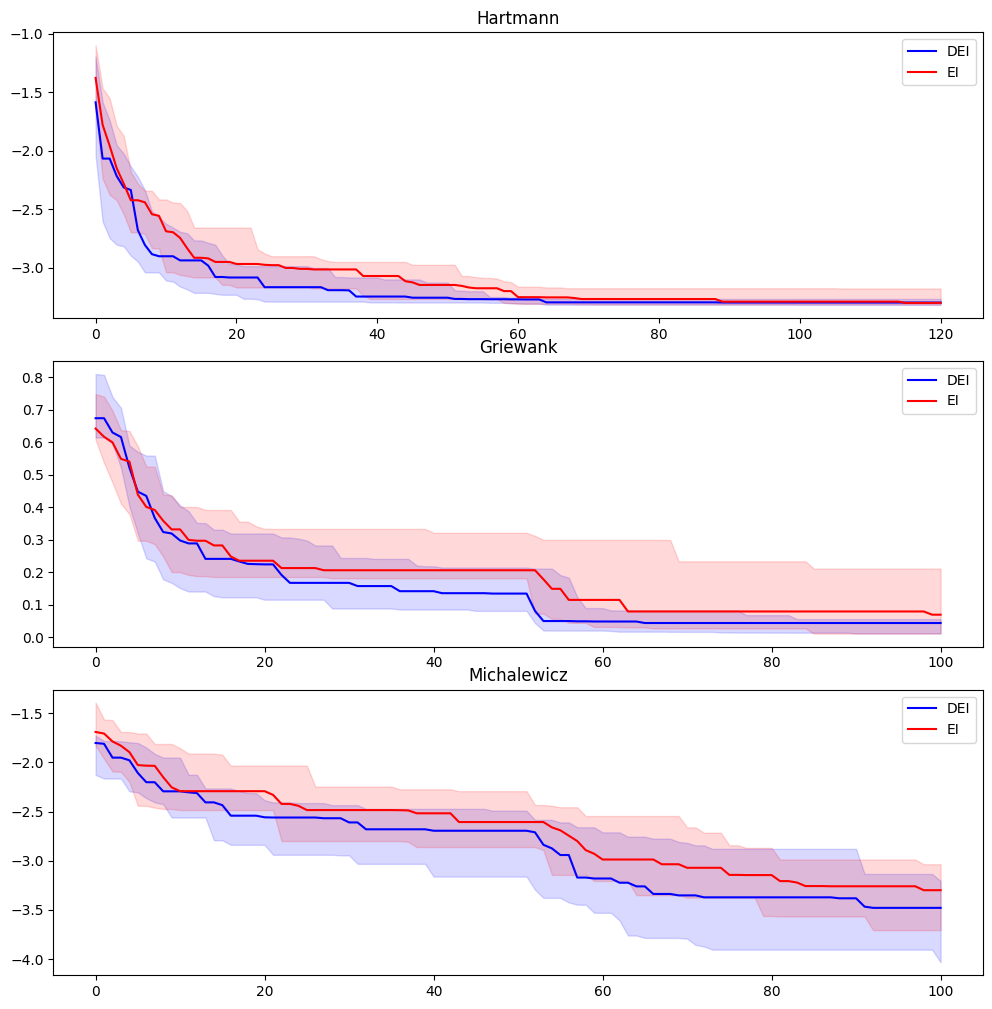

In [20]:
plot_min_sol(h_min_sol, 3, 2, include_lhc = False, start_index = 0)

In [21]:
h_results.groupby(['opt_func', 'acf_func'])[['curr_min', 'avg_dist', 'num_sol', 'num_cluster']].mean().reset_index()

,opt_func,acf_func,curr_min,avg_dist,num_sol,num_cluster
0,Griewank,DEI,0.066846,1.546805,33.76,1.40
1,Griewank,EI,0.123189,1.687643,13.16,1.28
2,Griewank,LHC,0.499774,-0.805863,0.40,1.00
3,Hartmann,DEI,-3.278876,0.404167,55.64,1.36
4,Hartmann,EI,-3.242878,0.583672,43.00,1.28
5,Hartmann,LHC,-2.133564,-0.267378,1.92,1.00
6,Michalewicz,DEI,-3.530858,0.500851,37.32,1.40
7,Michalewicz,EI,-3.275090,0.862834,15.48,1.32
8,Michalewicz,LHC,-2.183029,-0.752366,0.48,1.00


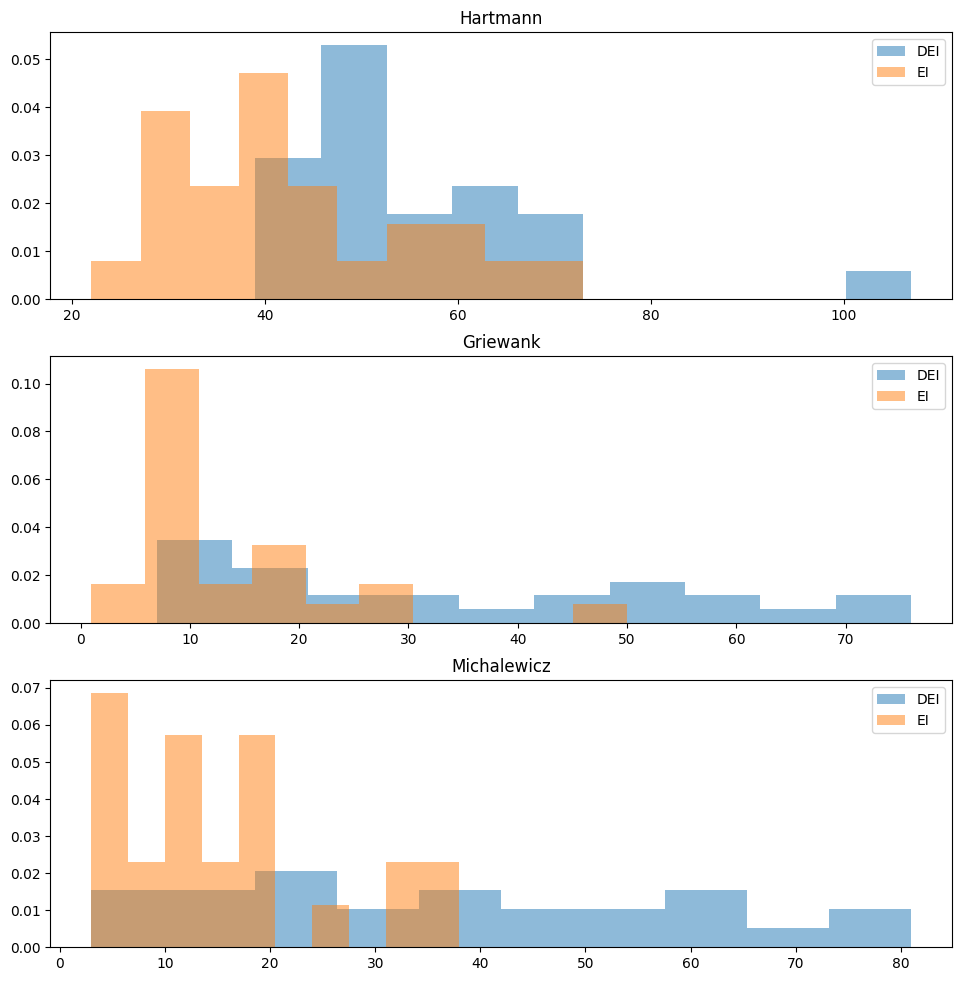

In [22]:
plot_feature_hist(h_results, 'num_sol')

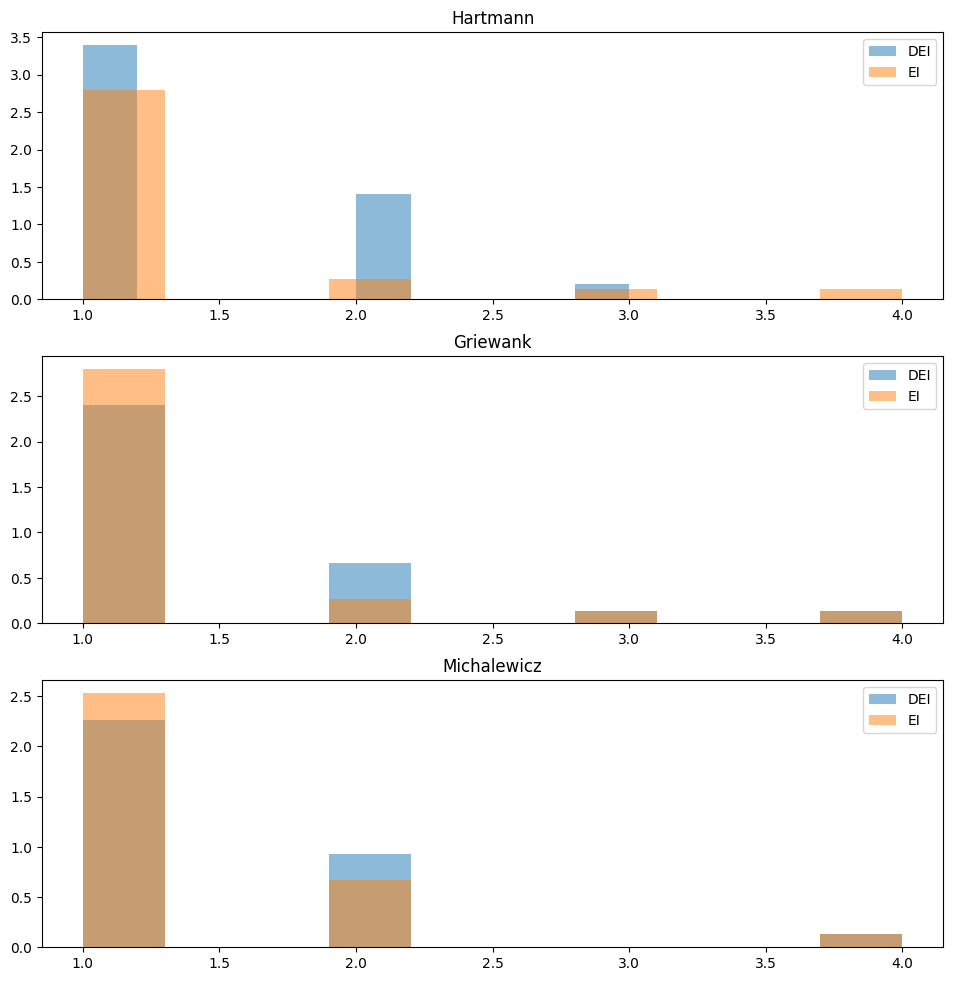

In [23]:
plot_feature_hist(h_results, 'num_cluster')

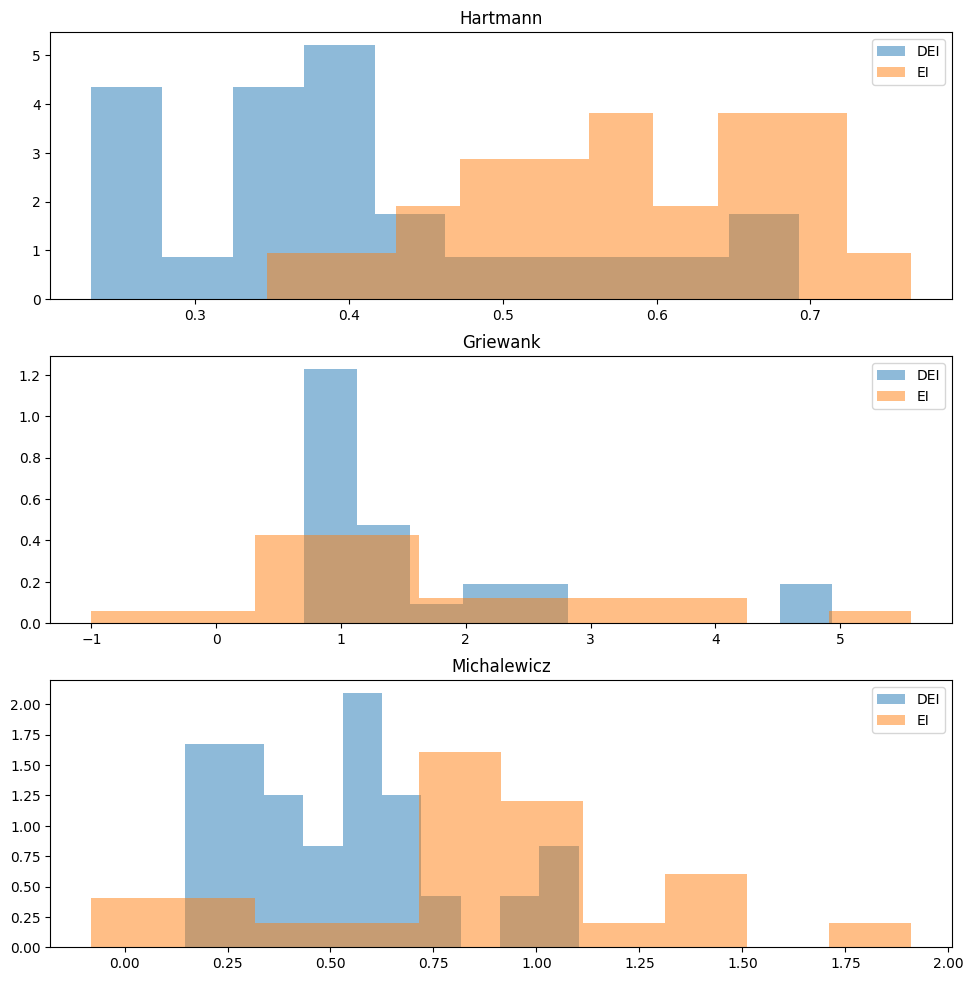

In [24]:
plot_feature_hist(h_results, 'avg_dist')

In [25]:
def grad_minimize(function, x0, step_size = 0.1, grad_lim = 0.001, max_iter = 500):
    
    dim = x0.shape[1]
    x0.requires_grad_
    
    x_current = x0
    y_current = function(x0)
    
    y_current.backward()
    ind = 0 
    
    while torch.norm(x_current.grad) >= grad_lim and ind < max_iter:
        x_new = torch.tensor(x_current - x_current.grad * step_size, requires_grad = True)
        y_new = function(x_new)
        x_current = x_new
        y_current = y_new
        y_current.backward()
        ind += 1

    return x_current, y_current

def minima_finding(function, dim, bounds, num_sol = 200):
    res_x = torch.zeros(num_sol, dim)
    res_y = torch.zeros(num_sol)
    for i in range(num_sol):
        init_point = revert_input(torch.rand(1, dim), bounds)
        init_point.requires_grad = True 
        x,y = grad_minimize(function, init_point)
        res_x[i] = x
        res_y[i] = y
    
    return res_x, res_y

def minima_finding_test(data, num_sol = 200):
    res_map = {}
    for function, bounds in data:
        res_x, res_y = minima_finding(function, bounds.shape[1],bounds, num_sol = num_sol)
        res_map[function.__class__.__name__] = (res_x, res_y)
    return res_map

In [26]:
func_list = [(Hartmann(dim = 6), torch.tensor([[0.0] * 6, [1.0] * 6])),
                 (Griewank(dim = 5), torch.tensor([[-5.0] * 5, [5.0] * 5])),
                 (Michalewicz(dim = 5), torch.tensor([[0.0] * 5, [3.14] * 5]))]

res_map = minima_finding_test(func_list, num_sol = 1000)

In [27]:
def calculate_wss(points, max_k = 10):
    sse = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += np.linalg.norm(curr_center - points[i]) ** 2
        sse.append(curr_sse)
    return sse

def calculate_sil(points, max_k = 10):
    sil = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters = k).fit(points)
        labels = kmeans.labels_
        sil.append(silhouette_score(points, labels, metric = 'euclidean'))
        
    return sil

def plot_clusters(res_map, max_k = 10, get_sil = False):
    
    fig, ax = plt.subplots(len(res_map))
    
    fig.tight_layout(pad = 1)
    ind = 0
    for func in res_map:
        
        metric_func = calculate_sil if get_sil else calculate_wss
        
        metric = metric_func(res_map[func][0].detach().numpy(), max_k)
        ax[ind].plot(np.arange(2, max_k + 1), metric)
        ax[ind].set_title(func)
        
        ind += 1

def get_optimal_centers(res_map, dim_ref = {'Hartmann':4, 'Griewank':20, 'Michalewicz':11}):
    
    cluster_center = {}
    for func in dim_ref:
        kmeans = KMeans(n_clusters = dim_ref[func]).fit(res_map[func][0].detach().numpy())
        cluster_center[func] = kmeans.cluster_centers_
    
    return cluster_center

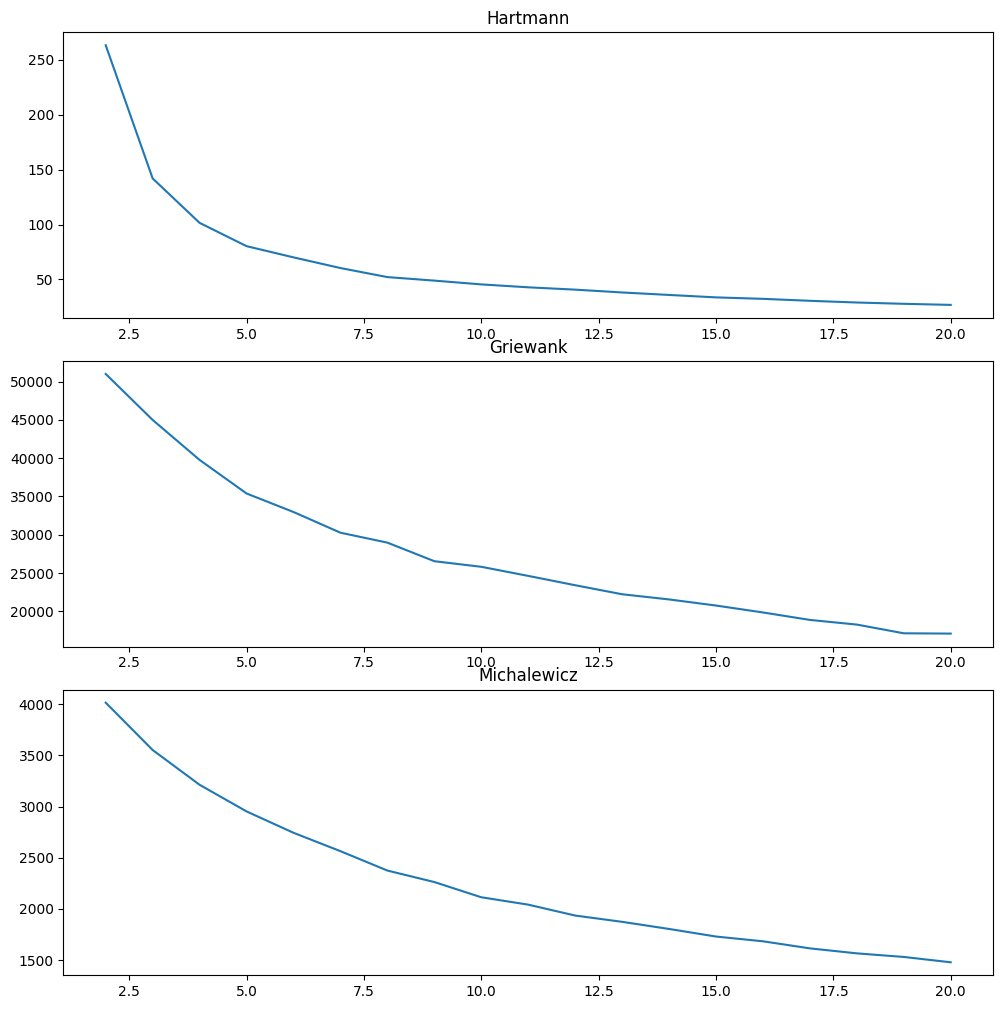

In [28]:
plot_clusters(res_map, get_sil = False, max_k = 20)

In [29]:
opt_cent = get_optimal_centers(res_map)

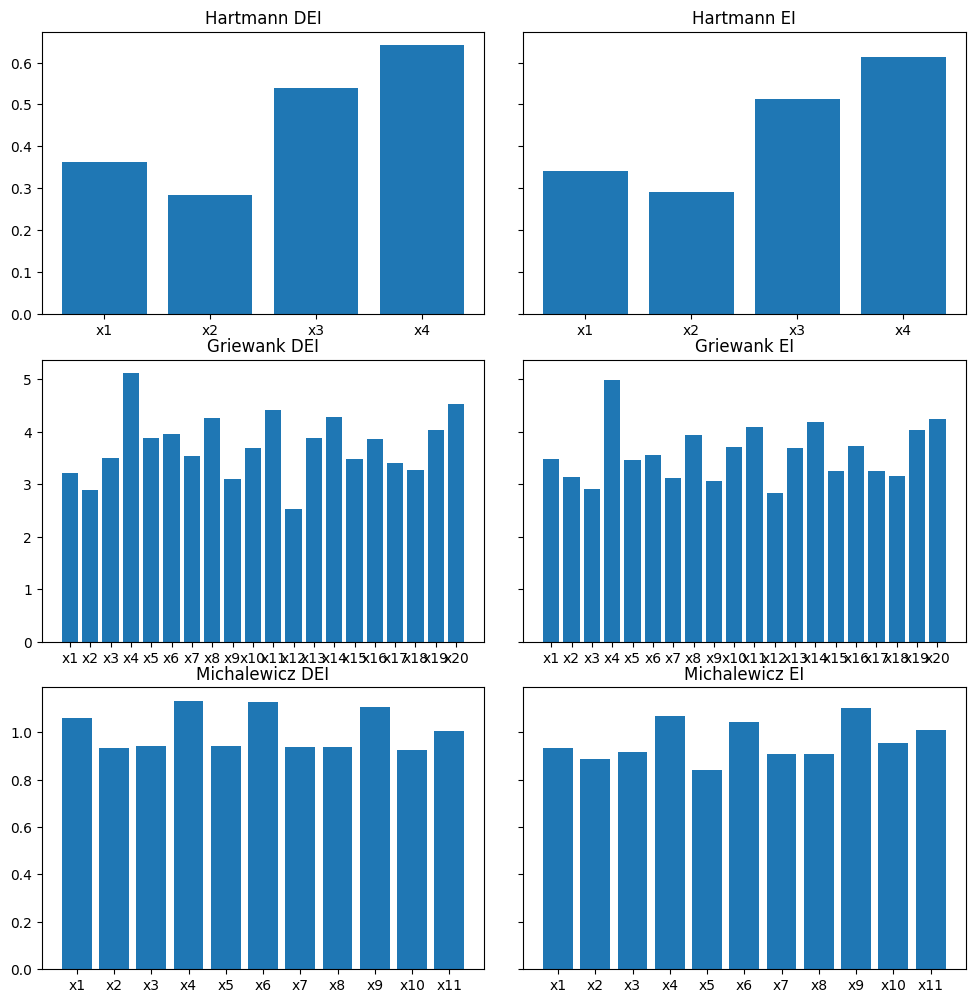

In [30]:
opt_cent = get_optimal_centers(res_map)
dist_metric_h = get_dist_metric(h_all_x, opt_cent, 25)
plot_dist_metric(dist_metric_h, num_func = 3)